code to predict pv generation

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.

'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
'''


# Third party packages.
import os                       # Execute tasks related to your operating system.

# import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

# from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [10]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
# pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{DOWNLOAD_DIR}power-gen-consolidated-data-2022-2024.csv'
solar_daily_csv_file_path = f'{DOWNLOAD_DIR}power-gen-type-2022-2024-2-day.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)


with open(solar_daily_csv_file_path, 'rb') as csv_solar_daily_file:
    df_pd_solar_daily = pd.read_csv(csv_solar_daily_file)


df_pd_no_solar = df_pd_orig

df_pd_orig['production_solar'] = df_pd_orig['volume_0'] - df_pd_orig.filter(like='production').sum(axis=1)
df_pd_orig.head(3)

df_pd_orig["Total_Production"] = df_pd_orig["volume_0"]

# Sum of all columns starting with 'production'
# df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
# df_pd_orig["Total_Production"] = df_pd_orig["production_all"]
# df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
# df_pd_orig.head(3)
# df_pd_solar_daily.head(3)


DOWNLOAD_DIR : ../data/powergen/


To draw line graph

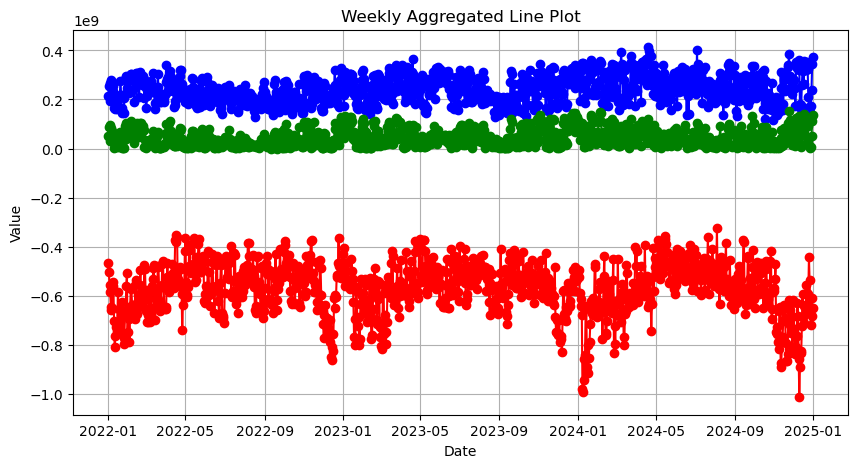

In [11]:
# Convert hr column to datetime (if not already)
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])
df_pd_solar_daily['validto'] = pd.to_datetime(df_pd_solar_daily['validto'])

# Resample by day and aggregate (e.g., taking the sum or mean)
df_daily = df_pd_orig.resample('D', on='validto').sum()  # You can use .mean(), .max(), etc.
# Extract only the day part
# print(df_daily.head(3))
df_daily['day'] = df_pd_orig['validto'].dt.day

plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Total_Production'], marker='o', linestyle='-', label='Total Production', color='b')
plt.plot(df_daily.index, df_daily['production_wind'], marker='o', linestyle='-', label='Total Wind Production', color='g')
plt.plot(df_daily.index, df_daily['production_solar'], marker='o', linestyle='-', label='Total Wind Production', color='r')


# df_daily.reset_index(inplace=True)

# df_pd_solar_daily['day'] = df_pd_solar_daily['validto'].dt.day
# print(df_pd_solar_daily.head(3))

# Merging DataFrames with an outer join
# merged_df_total = pd.merge(df_daily, df_pd_solar_daily, on='validto', how='inner')



# Plot the line graph
# plt.plot(merged_df_total.index, merged_df_total['volume'], marker='o', linestyle='-', label='Total Solar Production', color='r')


# Labels and Title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Weekly Aggregated Line Plot")
plt.grid()

plt.show()


Descriptive Statistics

In [11]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 49 numerical variables:
Index(['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2',
       'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8',
       'production_cofiring', 'capacity_9', 'production_geothermal',
       'capacity_10', 'production_other', 'capacity_11', 'production_waste',
       'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass',
       'capacity_14', 'production_wood', 'capacity_17',
       'production_windoffshore', 'capacity_18', 'production_fossilgaspower',
       'capacity_19', 'production_fossilhardcoal', 'capacity_20',
       'production_nuclear', 'capacity_21', 'production_wastepower',
       'capacity_22', 'production_windoffshoreB', 'capacity_25',
       'production_biomasspower', 'capacity_26', 'production_otherpower',
       'capacity_27', 'production_electricitymix', 'capacity_28', 'volume_28',
       'capacity_35', 'production_CHP_total', 'capacity_50',
       'production_solarthermal', 'c

To check if the output column has unique values

In [12]:
l_col = ['Total_Production']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Total_Production']:        Total_Production
0              27356962
1              26938533
2              25625865
3              24413196
4              23932535
...                 ...
26299          42375950
26300          41512334
26301          41166931
26302          40696878
26303          40381524

[26304 rows x 1 columns]
Total_Production: [27356962 26938533 25625865 ... 41166931 40696878 40381524]


Contruct a descriptive summary

In [13]:
df_pd_orig.describe()

,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,production_cofiring,...,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
count,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,26304.000000,26304.000000,...,2.630400e+04,6.377000e+03,6.377000e+03,2.630400e+04,2.630400e+04,26304.000000,26304.000000,2.630400e+04,2.630400e+04,2.630400e+04
mean,1.002881e+07,1.002881e+07,1.867822e+06,1.867822e+06,2.467901e+06,2.467901e+06,6.375008e+05,6.375008e+05,680711.491940,680711.491940,...,1.352914e+07,1.131498e+07,1.131498e+07,1.663086e+06,1.663086e+06,42418.259960,42418.259960,1.308883e+06,1.308883e+06,3.378853e+07
std,4.730942e+06,4.730942e+06,1.724212e+06,1.724212e+06,3.850288e+06,3.850288e+06,4.450993e+05,4.450993e+05,27603.187466,27603.187466,...,4.009711e+06,1.358170e+06,1.358170e+06,6.544200e+05,6.544200e+05,65692.270586,65692.270586,1.068610e+06,1.068610e+06,8.909114e+06
min,2.495282e+06,2.495282e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.925200e+04,3.925200e+04,600089.000000,600089.000000,...,3.476983e+06,3.885110e+06,3.885110e+06,4.414480e+05,4.414480e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,1.048418e+07
25%,6.201201e+06,6.201201e+06,3.823895e+05,3.823895e+05,0.000000e+00,0.000000e+00,2.965032e+05,2.965032e+05,674888.000000,674888.000000,...,1.049245e+07,1.096225e+07,1.096225e+07,1.177204e+06,1.177204e+06,355.000000,355.000000,3.720008e+05,3.720008e+05,2.716609e+07
50%,9.336639e+06,9.336639e+06,1.311126e+06,1.311126e+06,8.141500e+04,8.141500e+04,5.699665e+05,5.699665e+05,693450.000000,693450.000000,...,1.326964e+07,1.139893e+07,1.139893e+07,1.566794e+06,1.566794e+06,1933.000000,1933.000000,1.060625e+06,1.060625e+06,3.374067e+07
75%,1.302629e+07,1.302629e+07,3.046544e+06,3.046544e+06,3.826383e+06,3.826383e+06,8.631202e+05,8.631202e+05,699456.000000,699456.000000,...,1.640090e+07,1.220615e+07,1.220615e+07,2.025625e+06,2.025625e+06,63783.750000,63783.750000,2.090000e+06,2.090000e+06,4.005078e+07
max,2.918097e+07,2.918097e+07,6.518273e+06,6.518273e+06,1.973623e+07,1.973623e+07,3.208576e+06,3.208576e+06,699995.000000,699995.000000,...,2.967770e+07,1.488739e+07,1.488739e+07,3.940000e+06,3.940000e+06,296529.000000,296529.000000,4.342999e+06,4.342999e+06,7.158663e+07


To plot corelation matrix

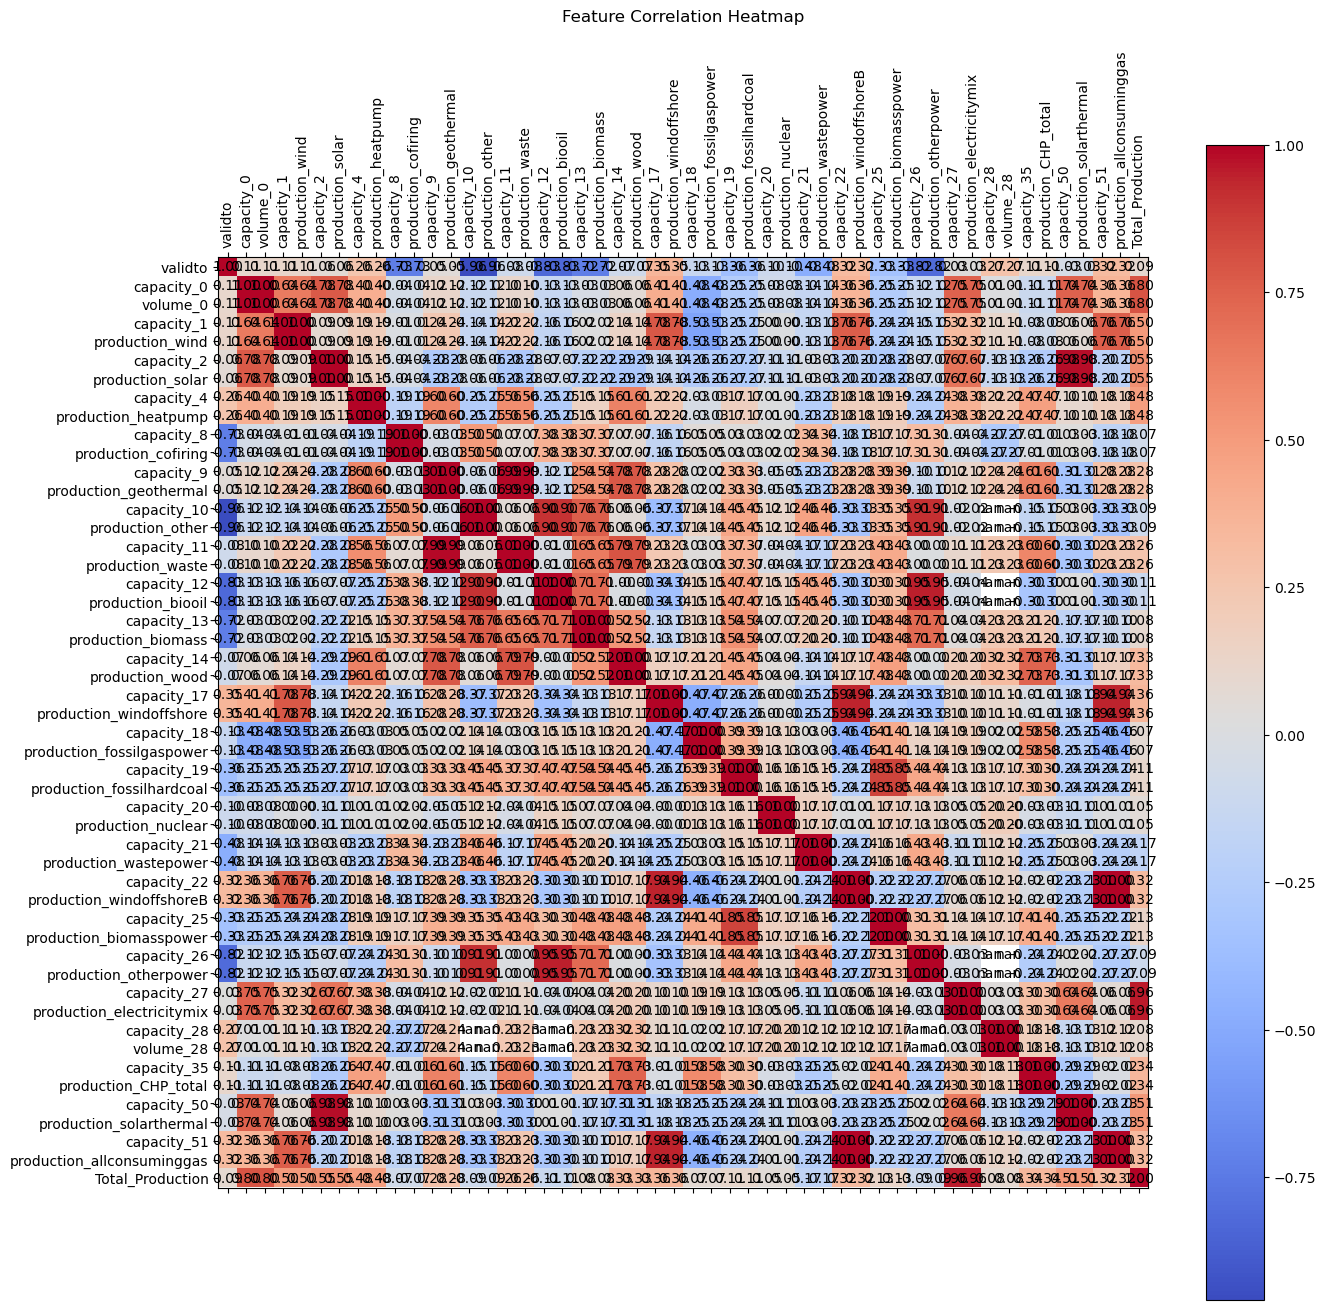

Columns removed due to low correlation with 'validto' (between -0.25 and 0.25):
['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2', 'production_solar', 'capacity_9', 'production_geothermal', 'capacity_11', 'production_waste', 'capacity_14', 'production_wood', 'capacity_18', 'production_fossilgaspower', 'capacity_20', 'production_nuclear', 'capacity_27', 'production_electricitymix', 'capacity_35', 'production_CHP_total', 'capacity_50', 'production_solarthermal', 'Total_Production']

Updated DataFrame:
26304


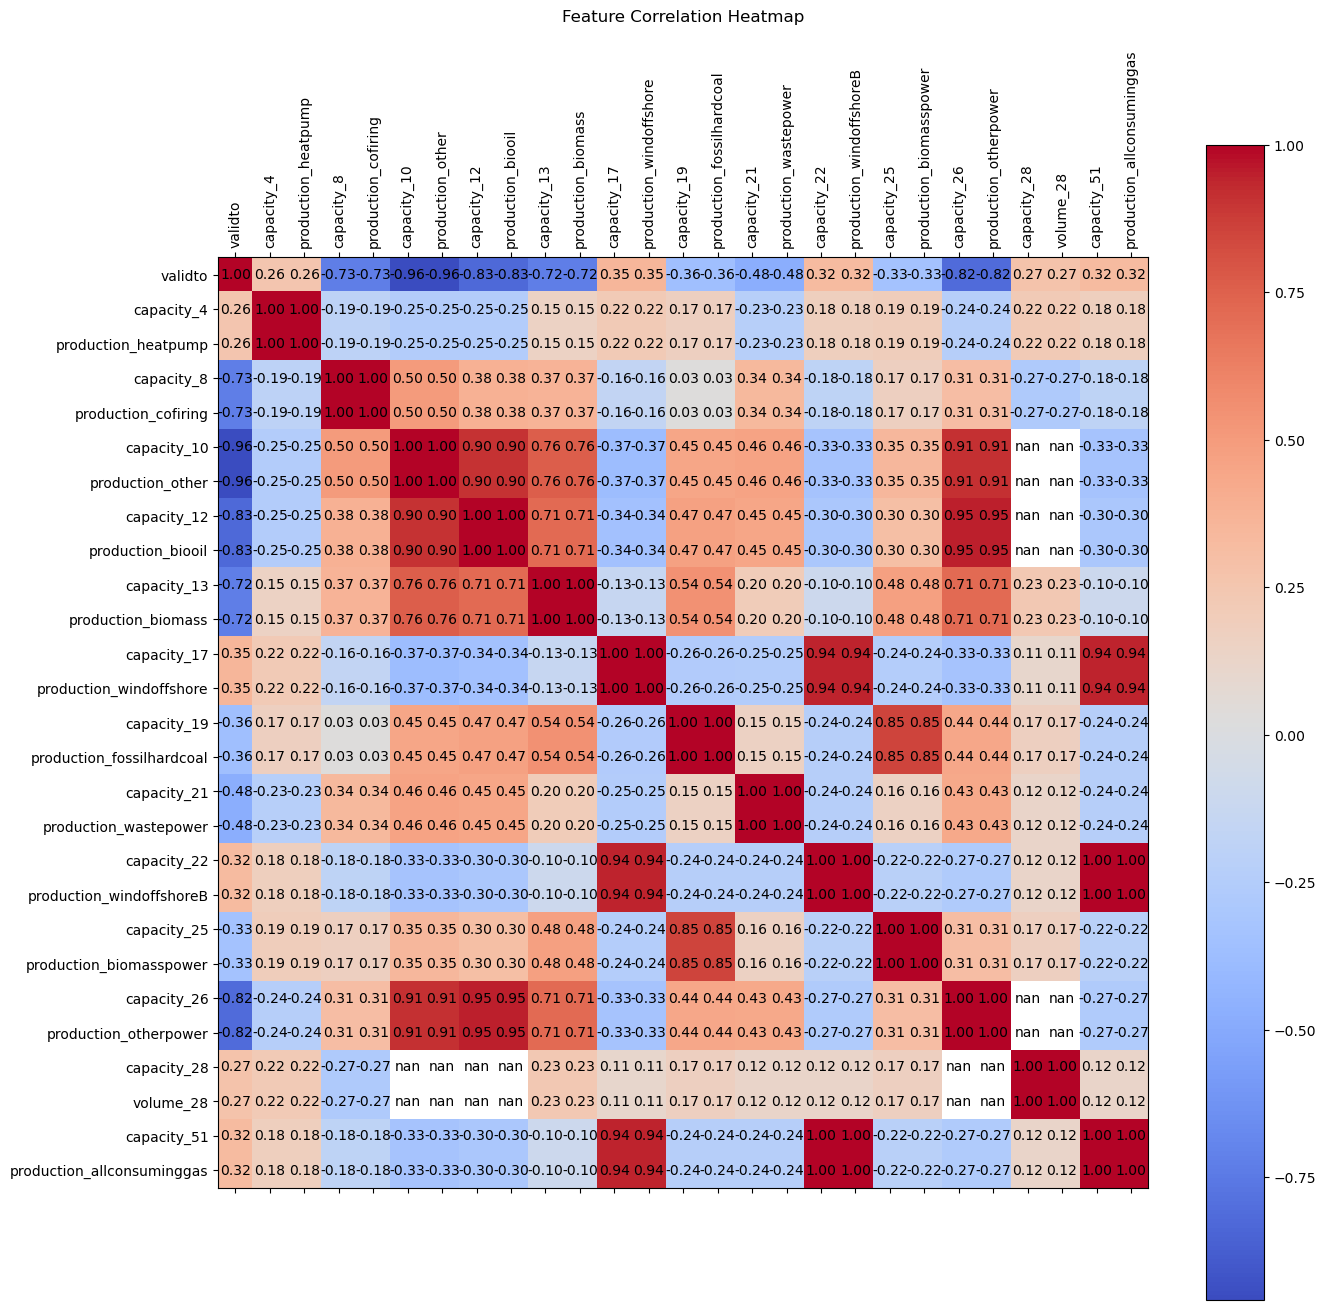

Columns removed due to low correlation (between -0.1 and 0.1):
['validto', 'capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2', 'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8', 'production_cofiring', 'capacity_9', 'production_geothermal', 'capacity_10', 'production_other', 'capacity_11', 'production_waste', 'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass', 'capacity_14', 'production_wood', 'capacity_17', 'production_windoffshore', 'capacity_18', 'production_fossilgaspower', 'capacity_19', 'production_fossilhardcoal', 'capacity_20', 'production_nuclear', 'capacity_21', 'production_wastepower', 'capacity_22', 'production_windoffshoreB', 'capacity_26', 'production_otherpower', 'capacity_27', 'production_electricitymix', 'capacity_28', 'volume_28', 'capacity_35', 'production_CHP_total', 'capacity_50', 'production_solarthermal', 'capacity_51', 'production_allconsuminggas', 'Total_Production']

Updated DataFrame:
26304


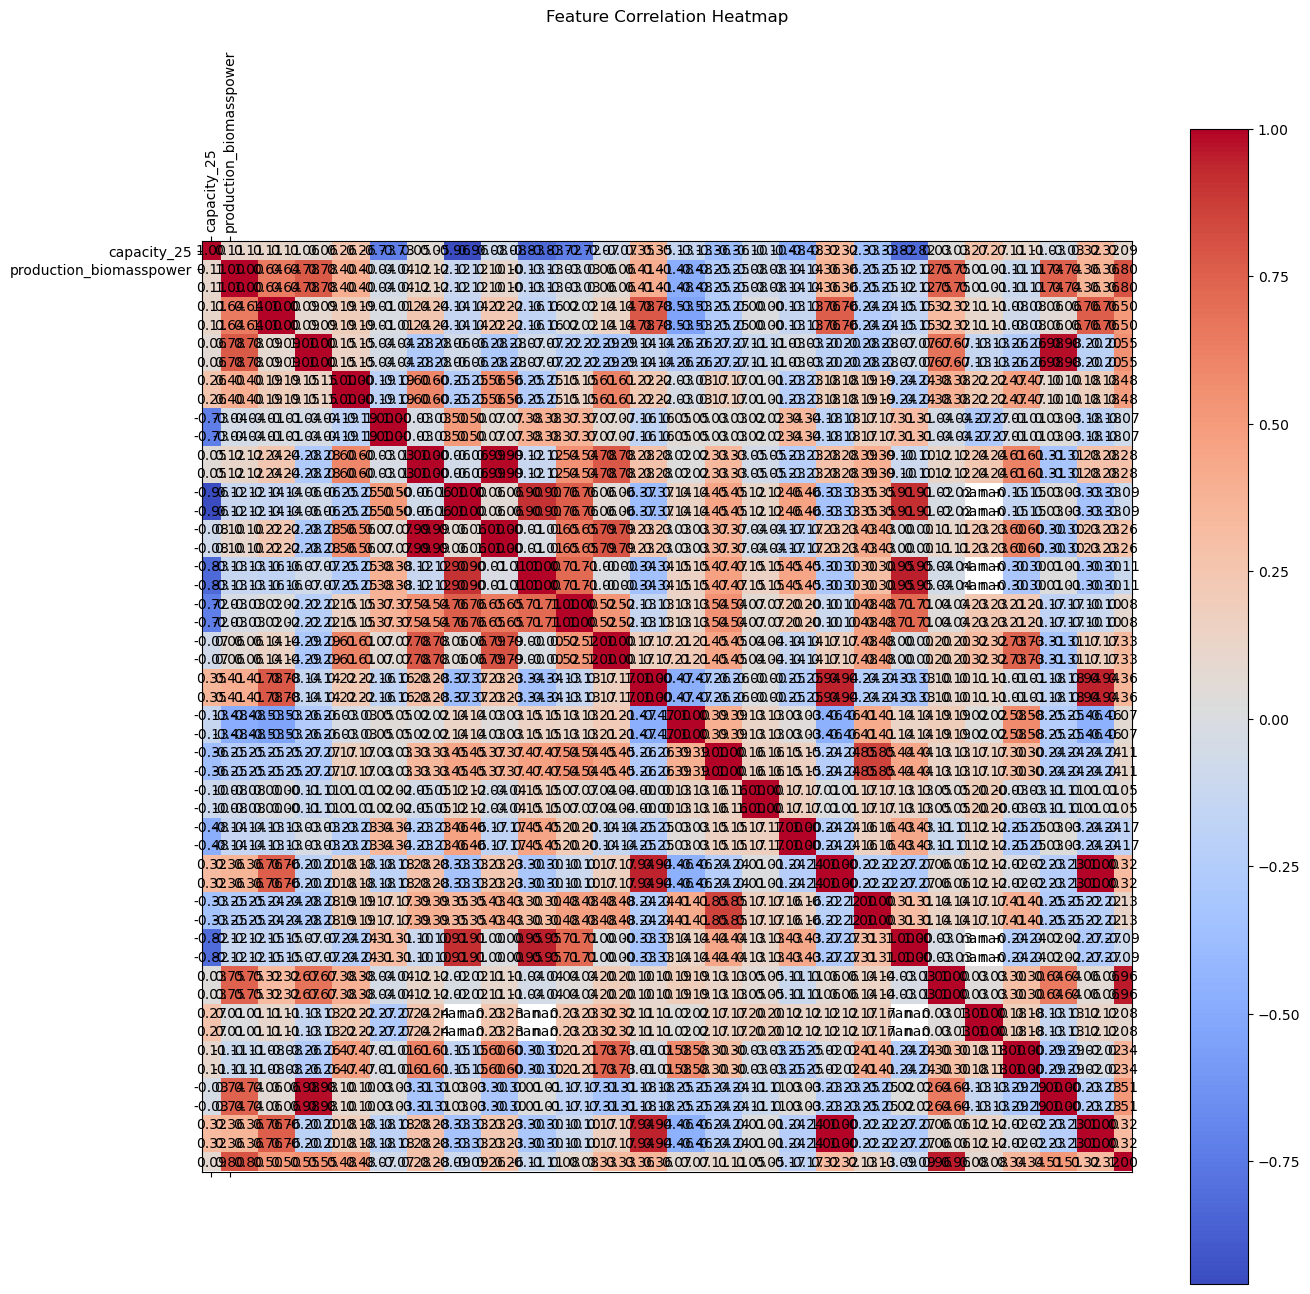

In [27]:
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Compute correlation matrix
corr_matrix = df_pd_orig.corr()

# Plot heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(corr_matrix, cmap="coolwarm")

# Add color bar
plt.colorbar(cax)

# Add feature names on axes
ax.set_xticks(range(len(df_pd_orig.columns)))
ax.set_yticks(range(len(df_pd_orig.columns)))
ax.set_xticklabels(df_pd_orig.columns, rotation=90)
ax.set_yticklabels(df_pd_orig.columns)

# Annotate the matrix with the correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')


plt.title("Feature Correlation Heatmap", pad=20)
plt.show()


# Get the correlation values with 'validto' column
validto_corr = corr_matrix['validto']
# Identify columns with correlation between -0.25 and 0.25 with 'validto'
columns_to_remove = validto_corr[(validto_corr >= -0.25) & (validto_corr <= 0.25)].index.tolist()
# Remove the columns with low correlation to 'validto'
df_filtered_validto = df_pd_orig.drop(columns=columns_to_remove)
# Print the columns that are removed
print("Columns removed due to low correlation with 'validto' (between -0.25 and 0.25):")
print(columns_to_remove)
# Print the updated DataFrame
print("\nUpdated DataFrame:")
print(df_filtered_validto.shape[0])

validto_corr_matrix = df_filtered_validto.corr()

# Plot heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(validto_corr_matrix, cmap="coolwarm")

# Add color bar
plt.colorbar(cax)

# Add feature names on axes
ax.set_xticks(range(len(df_filtered_validto.columns)))
ax.set_yticks(range(len(df_filtered_validto.columns)))
ax.set_xticklabels(df_filtered_validto.columns, rotation=90)
ax.set_yticklabels(df_filtered_validto.columns)

# Annotate the matrix with the correlation values
for i in range(len(validto_corr_matrix.columns)):
    for j in range(len(validto_corr_matrix.columns)):
        ax.text(j, i, f'{validto_corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')


plt.title("Feature Correlation Heatmap", pad=20)
plt.show()



# Create a mask to identify attributes with correlation values between -0.25 and 0.25
mask = (corr_matrix.abs() >= 0.1)  # Check absolute correlation > 0.25
# Get the list of columns that have correlation values between -0.25 and 0.25 (on the diagonal)
columns_to_remove = []
for column in corr_matrix.columns:
    for row in corr_matrix.index:
        if column != row and not mask.loc[row, column]:  # Exclude diagonal (self-correlation)
            columns_to_remove.append(column)
            break
# Remove the columns from the dataframe
df_filtered = df_pd_orig.drop(columns=set(columns_to_remove))
# Print columns to be removed
print("Columns removed due to low correlation (between -0.1 and 0.1):")
print(columns_to_remove)
# Print the updated DataFrame
print("\nUpdated DataFrame:")
print(df_filtered.shape[0])

# Plot heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(corr_matrix, cmap="coolwarm")

# Add color bar
plt.colorbar(cax)

# Add feature names on axes
ax.set_xticks(range(len(df_filtered.columns)))
ax.set_yticks(range(len(df_filtered.columns)))
ax.set_xticklabels(df_filtered.columns, rotation=90)
ax.set_yticklabels(df_filtered.columns)

# Annotate the matrix with the correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')


plt.title("Feature Correlation Heatmap", pad=20)
plt.show()


Prepare data for prediction

In [ ]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

# Step 3: Split the data into train and test based on time (using a percentage split)
train_size = int(len(df) * 0.8)  # 80% for training
train = df[:train_size].copy()  # Using the first 80% for training
test = df[train_size:].copy()   # Using the last 20% for testing


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

In [ ]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Total_Production']  # 'Total_Production' as the target

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['Total_Production']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

aic_lr = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Linear Regression", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

# 2️⃣ ARIMA Model (Example Order: (1,1,1))
arima_model = ARIMA(y_train, order=(1,1,1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
aic_arima = arima_model.aic  # Directly from ARIMA model

# Store results
results.append(["ARIMA (1,1,1)", 
                mean_absolute_error(y_test, y_pred_arima),
                np.sqrt(mean_squared_error(y_test, y_pred_arima)), 
                mean_absolute_percentage_error(y_test, y_pred_arima), 
                symmetric_mape(y_test, y_pred_arima), 
                aic_arima])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()


Predict using LASSO model

In [ ]:

# Train Lasso Regression Model
lasso = Lasso(alpha=0.2)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["LASSO", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])


Predict using decision tree regression

In [ ]:

# Train Decision Tree Regressor Model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["Decision Tree", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])



Predit using Random Forest regressor

In [ ]:

# Train Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=10000, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = rf_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

# Store results
results.append(["Random Forest", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

XGBoost Model

In [ ]:
# Create lag features
df['lag1'] = df['Total_Production'].shift(1)
df['lag2'] = df['Total_Production'].shift(2)
df.dropna(inplace=True)

# Train-Test Split
X = df[['lag1', 'lag2']]
y = df['Total_Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE:", mae)

# Plot Results
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Compute evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
smape_xgb = symmetric_mape(y_test, y_pred)
aic_xgb = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

# Append results to results
results.append(["XGBoost", mae_xgb, rmse_xgb, mape_xgb, smape_xgb, aic_xgb])


LTSM (Long Short-Term Memory)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = df_pd_orig

# Normalize data
scaler = MinMaxScaler()
df['Total_Production'] = scaler.fit_transform(df[['Total_Production']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Lookback period
data = df['Total_Production'].values
X, y = create_sequences(data, seq_length)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile & Train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict & Inverse Transform
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

# Compute evaluation metrics
mae_ltsm = mean_absolute_error(y_test, y_pred)
rmse_ltsm = np.sqrt(mean_squared_error(y_test, y_pred))
mape_ltsm = mean_absolute_percentage_error(y_test, y_pred)
smape_ltsm = symmetric_mape(y_test, y_pred)
aic_ltsm = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

print(mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm)

# Append results to results
results.append(["LSTM", mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm])

# Plot Results
import matplotlib.pyplot as plt
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted", color="red")
plt.legend()
plt.show()


Print Model evaluation results

In [ ]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE", "sMAPE", "AIC"])

# Display Table
print(metrics_df)